# Setup

Import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
from datetime import datetime
sns.set(style="darkgrid")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Path to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join("images")

def save_fig(fig_id, tight_layout=True, image_path=IMAGES_PATH):
    path = os.path.join(PROJECT_ROOT_DIR, image_path, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Get the Data

The data is split into a training set and a test set. In addition, the vehicles data is provided in the file `vehicle.csv`. All files are available in the directory `datasets`.

In [2]:
import os
import pandas as pd

DATA_PATH = os.path.join("datasets")

def load_transport_data(filename, data_path=DATA_PATH):
    csv_path = os.path.join(PROJECT_ROOT_DIR,data_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_transport_data('train.csv')
test_data = load_transport_data('test.csv')

C:\Users\geochatz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


## Take a Quick Look at the Data Structure

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136575 entries, 0 to 136574
Data columns (total 30 columns):
accident_id                                136575 non-null int64
location_easting_osgr                      136575 non-null float64
location_northing_osgr                     136575 non-null float64
longitude                                  136575 non-null float64
latitude                                   136575 non-null float64
number_of_vehicles                         136575 non-null int64
number_of_casualties                       136575 non-null int64
date                                       136575 non-null object
time                                       136575 non-null object
1st_road_class                             136575 non-null object
1st_road_number                            136575 non-null int64
road_type                                  136575 non-null object
speed_limit                                136575 non-null float64
junction_detail               

In [5]:
len(train_data.accident_id.unique())

136575

Each row represents one accident. The `info()` method shows the total number of rows and each attribute's type and number of the non-null values. There are 136575 instances in the dataset and the **id** per accident is unique as expected.

The data has different type of attributes, such as numerical. There are also attributes which type is object.

There are attributes which are sometimes null (less than 136575 non-null). The **junction_control** attribute for example has about 40% null values. The attributes **junction_control** and **2nd_road_class** will be removed since a lot of assumptions should be taken to fill the null-values.

In [6]:
train_data['target'].describe()

count    136575.000000
mean          0.171444
std           0.376898
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

From the total number of accidents 17% is a fatal accident (the mean in the **target** attribute), so the classes are imbalanced and accuracy won't be a reasonable metric to evaluate our model

## Create a Test Set

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(train_data, test_size=0.2, random_state=42)

In [8]:
train_set.target.describe()

count    109260.000000
mean          0.171353
std           0.376819
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [9]:
test_set.target.describe()

count    27315.000000
mean         0.171810
std          0.377222
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64

# Explore the Data to Get Insights

### Datetime Attributes

In [10]:
accident_data = train_set.copy()

In [11]:
date_attributes = ['date', 'time']
train_data[date_attributes].head()

,date,time
0,2016-01-11,02:30
1,2016-01-11,00:37
2,2016-01-11,01:25
3,2016-01-11,09:15
4,2016-01-11,07:53


Combine date and time and create one datetime attribute

In [12]:
accident_data['datetime'] = pd.to_datetime(accident_data['date'] + ' ' + accident_data['time'])

In [13]:
accident_data['datetime'][:5]

96365    2016-04-29 15:20:00
129456   2016-08-06 18:15:00
129441   2016-05-31 19:35:00
104030   2016-03-27 07:48:00
15911    2016-08-08 19:45:00
Name: datetime, dtype: datetime64[ns]

From datetime attribute extract the year, month, day, week, hour and minute of the accident

In [14]:
accident_data['year'] = accident_data['datetime'].dt.year
accident_data['month'] = accident_data['datetime'].dt.month
accident_data['day'] = accident_data['datetime'].dt.day
accident_data['week'] = accident_data['datetime'].dt.week
accident_data['hour'] = accident_data['datetime'].dt.hour
accident_data['minute'] = accident_data['datetime'].dt.minute

In [15]:
accident_data[['year','month','week','day','hour','minute']].head()

,year,month,week,day,hour,minute
96365,2016,4,17,29,15,20
129456,2016,8,31,6,18,15
129441,2016,5,22,31,19,35
104030,2016,3,12,27,7,48
15911,2016,8,32,8,19,45


### Categorical Attributes

In [16]:
accident_data = train_set.copy()

In [17]:
accident_data.select_dtypes(include=['object']).columns

Index(['date', 'time', '1st_road_class', 'road_type', 'junction_detail',
       'junction_control', '2nd_road_class',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'lsoa_of_accident_location', 'police_force',
       'local_authority_district', 'local_authority_highway'],
      dtype='object')

In [18]:
cat_attributes = ['1st_road_class', 
                   'road_type',
                   'junction_detail',
                   'pedestrian_crossing-human_control',
                   'pedestrian_crossing-physical_facilities',
                   'light_conditions',
                   'weather_conditions',
                   'road_surface_conditions',
                   'special_conditions_at_site', 
                   'carriageway_hazards',
                   'urban_or_rural_area',
                   'lsoa_of_accident_location', 
                   'police_force',
                   'local_authority_district',
                   'local_authority_highway']

In [19]:
accident_data[cat_attributes].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109260 entries, 96365 to 121958
Data columns (total 15 columns):
1st_road_class                             109260 non-null object
road_type                                  109260 non-null object
junction_detail                            109177 non-null object
pedestrian_crossing-human_control          109110 non-null object
pedestrian_crossing-physical_facilities    108767 non-null object
light_conditions                           109251 non-null object
weather_conditions                         109251 non-null object
road_surface_conditions                    108648 non-null object
special_conditions_at_site                 108857 non-null object
carriageway_hazards                        108830 non-null object
urban_or_rural_area                        109260 non-null object
lsoa_of_accident_location                  102609 non-null object
police_force                               109260 non-null object
local_authority_district   

In [20]:
accident_data[cat_attributes].head()

,1st_road_class,road_type,junction_detail,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location,police_force,local_authority_district,local_authority_highway
96365,Motorway,Roundabout,Roundabout,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Rural,E01023170,Hampshire,Test Valley,Hampshire
129456,Unclassified,Single carriageway,T or staggered junction,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,NaN,Tayside,Dundee City,Dundee City
129441,Unclassified,Single carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,NaN,Tayside,Dundee City,Dundee City
104030,Motorway,Dual carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Raining no high winds,Wet or damp,None,None,Rural,E01024628,Kent,Swale,Kent
15911,A,Dual carriageway,T or staggered junction,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,E01003107,Metropolitan Police,Lambeth,Lambeth


In [21]:
accident_data['1st_road_class'].value_counts()

A               49230
Unclassified    34837
B               13354
C                7530
Motorway         3975
A(M)              334
Name: 1st_road_class, dtype: int64

In [22]:
accident_data['road_type'].value_counts()

Single carriageway    81361
Dual carriageway      16041
Roundabout             7128
One way street         2477
Slip road              1147
Unknown                1106
Name: road_type, dtype: int64

In [23]:
accident_data['lsoa_of_accident_location_slc']=accident_data[['lsoa_of_accident_location']].apply(lambda x: x.str.slice(0, 6))

In [24]:
accident_data['lsoa_of_accident_location_slc'].value_counts()

E01004    4002
E01003    3984
E01002    3980
E01030    3740
E01001    3673
E01024    3647
E01000    3517
E01033    3468
E01031    3152
E01026    3071
E01013    3039
E01023    3024
E01032    3003
E01018    2986
E01015    2964
E01016    2850
E01017    2841
E01021    2818
E01025    2789
E01027    2771
E01029    2744
E01028    2730
E01012    2636
E01009    2605
E01019    2535
E01010    2525
E01020    2518
E01011    2517
E01007    2454
E01022    2356
E01014    2342
E01008    2337
W01000    2264
W01001    1708
E01006    1653
E01005    1366
Name: lsoa_of_accident_location_slc, dtype: int64

In [25]:
accident_data['police_force'].value_counts()

Metropolitan Police      19842
West Midlands             4703
Kent                      4032
West Yorkshire            3955
Thames Valley             3889
Hampshire                 3514
Sussex                    3334
Surrey                    3002
Essex                     2985
Strathclyde               2940
Lancashire                2920
Devon and Cornwall        2806
South Yorkshire           2463
Avon and Somerset         2459
Greater Manchester        2318
Northumbria               2222
Hertfordshire             2126
Nottinghamshire           2077
Staffordshire             2062
Merseyside                1937
Cheshire                  1899
Humberside                1886
West Mercia               1856
Cambridgeshire            1754
Leicestershire            1753
South Wales               1653
North Yorkshire           1644
Lothian and Borders       1610
Lincolnshire              1599
Derbyshire                1528
Norfolk                   1486
Wiltshire                 1281
Suffolk 

In [26]:
accident_data['local_authority_district'].value_counts()

Birmingham                     2234
Leeds                          1534
Westminster                    1228
Glasgow City                   1028
Lambeth                        1015
Cornwall                        964
Sheffield                       939
Bradford                        920
Edinburgh, City of              918
Wiltshire                       879
Tower Hamlets                   877
Bristol, City of                823
Ealing                          814
Southwark                       812
Liverpool                       797
Barnet                          764
Wandsworth                      752
Nottingham                      729
Brent                           726
Hackney                         723
Croydon                         720
Lewisham                        710
Hounslow                        705
Haringey                        700
Newham                          687
Cheshire East                   683
Leicester                       677
Camden                      

In [27]:
accident_data['local_authority_highway'].value_counts()

Kent                                    3534
Surrey                                  3002
Hampshire                               2395
Essex                                   2384
Lancashire                              2240
Birmingham                              2234
Hertfordshire                           2126
Lincolnshire                            1599
West Sussex                             1597
Staffordshire                           1539
Leeds                                   1534
Norfolk                                 1486
Nottinghamshire                         1348
Suffolk                                 1279
Cambridgeshire                          1265
North Yorkshire                         1255
Westminster                             1228
Oxfordshire                             1203
Devon                                   1201
Warwickshire                            1164
East Sussex                             1107
Derbyshire                              1105
Glasgow Ci

In [28]:
accident_data['special_conditions_at_site'].value_counts()

None                                          106556
Roadworks                                       1153
Mud                                              260
Oil or diesel                                    255
Road surface defective                           238
Auto traffic signal - out                        234
Road sign or marking defective or obscured       121
Auto signal part defective                        40
Name: special_conditions_at_site, dtype: int64

In [29]:
accident_data['carriageway_hazards'].value_counts()

None                                               107071
Other object on road                                  780
Any animal in carriageway (except ridden horse)       458
Pedestrian in carriageway - not injured               205
Vehicle load on road                                  161
Previous accident                                     155
Name: carriageway_hazards, dtype: int64

Saving figure categorical_attributes_histogram


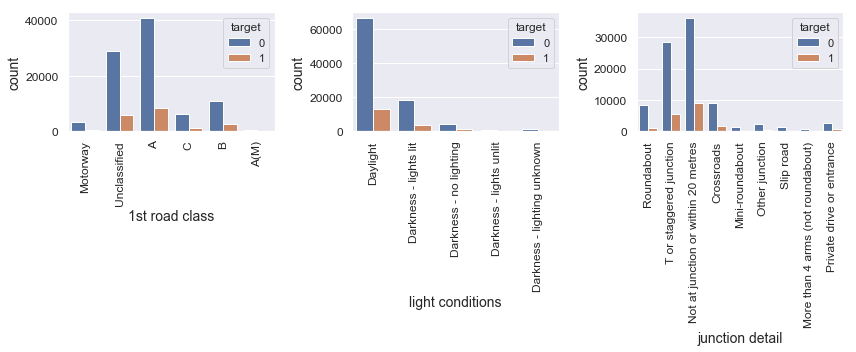

In [30]:
plt.figure(figsize=(12,5))
ax1=plt.subplot(131)
sns.countplot(x="1st_road_class", hue='target',data=accident_data, ax=ax1)
plt.xticks(rotation=90)
plt.xlabel('1st road class')

ax2 = plt.subplot(132)
sns.countplot(x="light_conditions", hue='target',data=accident_data, ax=ax2)
plt.xticks(rotation=90)
plt.xlabel('light conditions')

ax3=plt.subplot(133)
sns.countplot(x="junction_detail", hue='target',data=accident_data, ax=ax3)
plt.xticks(rotation=90)
plt.xlabel('junction detail')

save_fig("categorical_attributes_histogram")
plt.show()

### Numerical Attributes

In [31]:
accident_data = train_set.copy()

In [32]:
accident_data.select_dtypes(include=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109260 entries, 96365 to 121958
Data columns (total 11 columns):
accident_id               109260 non-null int64
location_easting_osgr     109260 non-null float64
location_northing_osgr    109260 non-null float64
longitude                 109260 non-null float64
latitude                  109260 non-null float64
number_of_vehicles        109260 non-null int64
number_of_casualties      109260 non-null int64
1st_road_number           109260 non-null int64
speed_limit               109260 non-null float64
2nd_road_number           108783 non-null float64
target                    109260 non-null int64
dtypes: float64(6), int64(5)
memory usage: 10.0 MB


In [33]:
accident_data.select_dtypes(include=['int64', 'float64']).columns

Index(['accident_id', 'location_easting_osgr', 'location_northing_osgr',
       'longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties',
       '1st_road_number', 'speed_limit', '2nd_road_number', 'target'],
      dtype='object')

In [34]:
num_attributes = ['location_easting_osgr',
                  'location_northing_osgr',
                  'longitude',
                  'latitude', 
                  'number_of_vehicles',
                  'number_of_casualties',
                  '1st_road_number',
                  'speed_limit',
                  '2nd_road_number']

In [35]:
accident_data[num_attributes].describe()

,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,1st_road_number,speed_limit,2nd_road_number
count,109260.000000,1.092600e+05,109260.000000,109260.000000,109260.000000,109260.000000,109260.000000,109260.000000,108783.000000
mean,448937.590838,2.880173e+05,-1.301422,52.479528,1.850201,1.328016,925.044920,37.955153,323.153848
std,95176.816820,1.568003e+05,1.398171,1.412061,0.711299,0.793772,1757.160982,14.051479,1205.617431
min,76702.000000,1.107500e+04,-7.389809,49.919716,1.000000,1.000000,0.000000,20.000000,0.000000
25%,386731.000000,1.763900e+05,-2.199677,51.473550,1.000000,1.000000,0.000000,30.000000,0.000000
50%,454425.500000,2.367310e+05,-1.197291,52.017065,2.000000,1.000000,66.000000,30.000000,0.000000
75%,527770.000000,3.893665e+05,-0.158571,53.398617,2.000000,1.000000,644.000000,40.000000,0.000000
max,655203.000000,1.178623e+06,1.756599,60.490191,16.000000,58.000000,9918.000000,70.000000,9999.000000


Saving figure attribute_histogram_plots


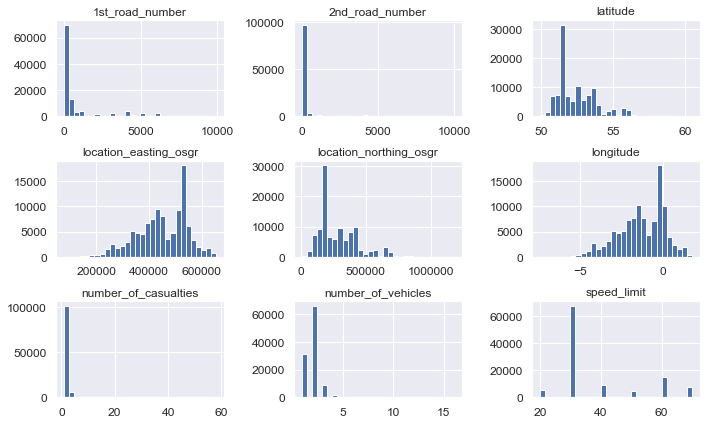

In [36]:
accident_data[num_attributes].hist(bins=30, figsize=(10,6))
save_fig("attribute_histogram_plots")
plt.show()

In [37]:
accident_data.corr()

,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,1st_road_number,speed_limit,2nd_road_number,target
accident_id,1.000000,0.002004,-0.002156,0.002075,-0.002160,0.000566,-0.001519,-0.002635,0.001773,-0.002964,0.002239
location_easting_osgr,0.002004,1.000000,-0.445930,0.999383,-0.448141,0.010667,-0.036682,-0.115188,-0.073345,-0.028757,-0.039648
location_northing_osgr,-0.002156,-0.445930,1.000000,-0.455514,0.999972,-0.020433,0.023989,0.041817,0.060014,0.018686,0.031377
longitude,0.002075,0.999383,-0.455514,1.000000,-0.457623,0.011211,-0.035494,-0.112799,-0.072462,-0.027318,-0.039174
latitude,-0.002160,-0.448141,0.999972,-0.457623,1.000000,-0.020307,0.024099,0.043026,0.059771,0.019483,0.031414
number_of_vehicles,0.000566,0.010667,-0.020433,0.011211,-0.020307,1.000000,0.247041,-0.012272,0.116126,0.013191,-0.079648
number_of_casualties,-0.001519,-0.036682,0.023989,-0.035494,0.024099,0.247041,1.000000,0.003852,0.161956,-0.005051,0.058778
1st_road_number,-0.002635,-0.115188,0.041817,-0.112799,0.043026,-0.012272,0.003852,1.000000,-0.044957,0.200435,0.009492
speed_limit,0.001773,-0.073345,0.060014,-0.072462,0.059771,0.116126,0.161956,-0.044957,1.000000,-0.032394,0.077153
2nd_road_number,-0.002964,-0.028757,0.018686,-0.027318,0.019483,0.013191,-0.005051,0.200435,-0.032394,1.000000,-0.013349


Saving figure bad_visualization_plot


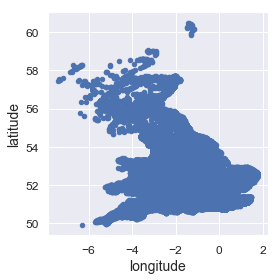

In [38]:
accident_data.plot(kind="scatter", x="longitude", y="latitude", figsize=(4,4))
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


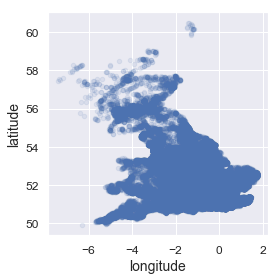

In [39]:
accident_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(4,4))
save_fig("better_visualization_plot")

Saving figure UK_accidents_scatterplot


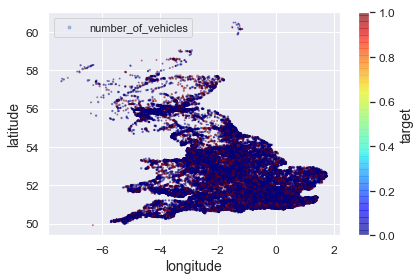

In [40]:
accident_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=accident_data["number_of_vehicles"], label="number_of_vehicles", figsize=(6,4),
    c="target", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("UK_accidents_scatterplot")

## Merge with Vehicles Dataset

In [41]:
vehicles_data = load_transport_data('vehicles.csv')

In [42]:
vehicles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451396 entries, 0 to 451395
Data columns (total 22 columns):
accident_id                         451396 non-null int64
Vehicle_Reference                   451396 non-null int64
Vehicle_Type                        450779 non-null object
Towing_and_Articulation             448721 non-null object
Vehicle_Manoeuvre                   448705 non-null object
Vehicle_Location-Restricted_Lane    448684 non-null object
Junction_Location                   449410 non-null object
Skidding_and_Overturning            448522 non-null object
Hit_Object_in_Carriageway           448311 non-null object
Vehicle_Leaving_Carriageway         448490 non-null object
Hit_Object_off_Carriageway          449570 non-null object
1st_Point_of_Impact                 448590 non-null object
Was_Vehicle_Left_Hand_Drive?        447677 non-null object
Journey_Purpose_of_Driver           451363 non-null object
Sex_of_Driver                       451351 non-null object
Age_of

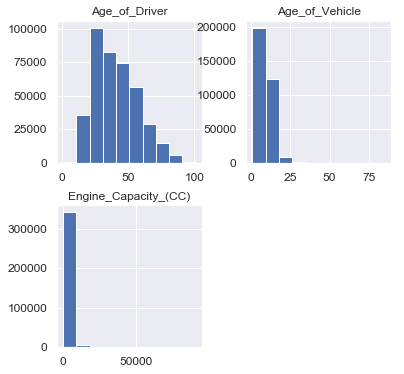

In [43]:
vehicles_data[['Age_of_Driver', 'Age_of_Vehicle', 'Engine_Capacity_(CC)']].hist(figsize=(6,6))
plt.show()

In [44]:
vehicles_data['AgeBucket'] = vehicles_data['Age_of_Driver'] // 10 * 10
vehicles_data.groupby('AgeBucket')[['AgeBucket']].sum()
#vehicles_data.head()

,AgeBucket
AgeBucket,
0.0,0.0
10.0,268440.0
20.0,1929720.0
30.0,2611140.0
40.0,2982520.0
50.0,3025850.0
60.0,1842660.0
70.0,1112650.0
80.0,569920.0


In [45]:
vehicles_data['count'] = 1

In [46]:
vehicles_data.groupby(['accident_id', 'AgeBucket'])['count'].sum().unstack().fillna(0).head()

AgeBucket,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
accident_id,,,,,,,,,,,
300000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
300002,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
300003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300004,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
vehicles_data[['Engine_Capacity_(CC)']].describe()

,Engine_Capacity_(CC)
count,347911.000000
mean,1869.255712
std,1627.516805
min,1.000000
25%,1248.000000
50%,1598.000000
75%,1995.000000
max,91000.000000


In [48]:
vehicles_data.groupby(['accident_id', 'Vehicle_Type'])['count'].sum().unstack().fillna(0).head()

Vehicle_Type,Agricultural vehicle,Bus or coach (17 or more pass seats),Car,Electric motorcycle,Goods 7.5 tonnes mgw and over,Goods over 3.5t. and under 7.5t,Goods vehicle - unknown weight,Minibus (8 - 16 passenger seats),Mobility scooter,Motorcycle - unknown cc,Motorcycle 125cc and under,Motorcycle 50cc and under,Motorcycle over 125cc and up to 500cc,Motorcycle over 500cc,Other vehicle,Pedal cycle,Ridden horse,Taxi/Private hire car,Tram,Van / Goods 3.5 tonnes mgw or under
accident_id,,,,,,,,,,,,,,,,,,,,
300000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
300001,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300002,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
300003,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
vehicles_data.groupby(['accident_id', 'Was_Vehicle_Left_Hand_Drive?'])['count'].sum().unstack().fillna(0).head()

Was_Vehicle_Left_Hand_Drive?,No,Yes
accident_id,,
300000,2.0,0.0
300001,2.0,0.0
300002,2.0,0.0
300003,1.0,0.0
300004,2.0,0.0


In [50]:
vehicles_data.groupby(['accident_id', 'Junction_Location'])['count'].sum().unstack().fillna(0).head()

Junction_Location,Approaching junction or waiting/parked at junction approach,Cleared junction or waiting/parked at junction exit,Entering from slip road,Entering main road,Entering roundabout,Leaving main road,Leaving roundabout,Mid Junction - on roundabout or on main road,Not at or within 20 metres of junction
accident_id,,,,,,,,,
300000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
300002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
300003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
300004,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [51]:
vehicles_data.loc[vehicles_data.accident_id==300000]

,accident_id,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,AgeBucket,count
224646,300000,1,Car,No tow/articulation,Overtaking static vehicle - offside,On main c'way - not in restricted lane,Cleared junction or waiting/parked at junction...,None,None,Did not leave carriageway,...,Female,20.0,1086.0,Petrol,11.0,6.0,1.0,6.0,20.0,1
224647,300000,2,Van / Goods 3.5 tonnes mgw or under,No tow/articulation,Going ahead other,On main c'way - not in restricted lane,Approaching junction or waiting/parked at junc...,None,None,Did not leave carriageway,...,Not known,NaN,1753.0,Heavy oil,12.0,NaN,NaN,NaN,NaN,1


In [52]:
pd.pivot_table(vehicles_data, index='accident_id', values=['Age_of_Vehicle', 'Age_of_Driver'], aggfunc='mean').head()

,Age_of_Driver,Age_of_Vehicle
accident_id,,
300000,20.0,11.5
300001,41.0,NaN
300002,55.5,22.0
300003,17.0,9.0
300004,34.0,2.0


In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddVehiclesAttributes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        print('AddVehiclesAttributes fit')
        return self
    
    def transform(self, X, y=None):
        print('AddVehiclesAttributes transform')
        
        cat_attributes = [
            'Sex_of_Driver',
            'Vehicle_Type',
            'Was_Vehicle_Left_Hand_Drive?',
            'Junction_Location']
        
        for attr in cat_attributes:
            X = AddVehiclesAttributes.merge_categorical_vehicle_attribute(X, col=attr)
            
        X = AddVehiclesAttributes.merge_numerical_vehicle_attribute(X)
        
        return X
    
    @staticmethod
    def merge_categorical_vehicle_attribute(X, col='Sex_of_Driver'):
        vehicles_data = load_transport_data('vehicles.csv')
        vehicles_data['counts'] = 1
        vehicles_cat = vehicles_data.groupby(['accident_id',col])['counts'].sum().unstack().fillna(0)
        return pd.merge(left=X, right=vehicles_cat, left_on='accident_id', right_index=True)
    
    @staticmethod
    def merge_numerical_vehicle_attribute(X):
        vehicles_data = load_transport_data('vehicles.csv')
        return pd.merge(left=X, 
                        right=pd.pivot_table(vehicles_data,
                                             index='accident_id', 
                                             values=['Age_of_Driver', 'Age_of_Vehicle', 'Engine_Capacity_(CC)'],
                                             aggfunc='mean'),
                        left_on='accident_id',
                        right_index=True)

In [54]:
vehicle_adder = AddVehiclesAttributes()

In [55]:
accident_with_vehicles = vehicle_adder.fit_transform(accident_data)
accident_with_vehicles.info()

AddVehiclesAttributes fit
AddVehiclesAttributes transform
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105828 entries, 96365 to 121958
Data columns (total 67 columns):
accident_id                                                    105828 non-null int64
location_easting_osgr                                          105828 non-null float64
location_northing_osgr                                         105828 non-null float64
longitude                                                      105828 non-null float64
latitude                                                       105828 non-null float64
number_of_vehicles                                             105828 non-null int64
number_of_casualties                                           105828 non-null int64
date                                                           105828 non-null object
time                                                           105828 non-null object
1st_road_class                                      

In [56]:
accident_with_vehicles.head()

,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,date,time,1st_road_class,...,Entering from slip road,Entering main road,Entering roundabout,Leaving main road,Leaving roundabout,Mid Junction - on roundabout or on main road,Not at or within 20 metres of junction,Age_of_Driver,Age_of_Vehicle,Engine_Capacity_(CC)
96365,320754,436967.0,116357.0,-1.475189,50.945410,4,1,2016-04-29,15:20,Motorway,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,37.250000,3.666667,1678.666667
129456,382572,341017.0,731306.0,-2.958981,56.470229,3,2,2016-08-06,18:15,Unclassified,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.666667,2.000000,1242.000000
129441,301060,339991.0,733454.0,-2.976128,56.489394,1,1,2016-05-31,19:35,Unclassified,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,2.000000,1248.000000
104030,463285,591484.0,158928.0,0.745259,51.297211,1,1,2016-03-27,07:48,Motorway,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,27.000000,4.000000,1560.000000
15911,494190,531230.0,178310.0,-0.111251,51.488465,2,1,2016-08-08,19:45,A,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,46.500000,7.000000,1797.000000


# Preparing Data for ML

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical, categorical or datetime columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        print('DataFrameSelector fit')
        return self
    
    def transform(self, X):
        print('DataFrameSelector transform')
        print('attributes names:', self.attribute_names)
        return X[self.attribute_names]

## Handling Categorical Attributes

In [58]:
accident_data = train_set.copy()

In [59]:
accident_and_vehicles_data = vehicle_adder.fit_transform(accident_data)

AddVehiclesAttributes fit
AddVehiclesAttributes transform


In [60]:
accident_and_vehicles_data.select_dtypes(include='object').columns

Index(['date', 'time', '1st_road_class', 'road_type', 'junction_detail',
       'junction_control', '2nd_road_class',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'lsoa_of_accident_location', 'police_force',
       'local_authority_district', 'local_authority_highway'],
      dtype='object')

In [61]:
cat_attributes = ['1st_road_class',
                  'road_type',
                  'junction_detail',
                  'pedestrian_crossing-human_control',
                  'pedestrian_crossing-physical_facilities',
                  'light_conditions',
                  'weather_conditions', 
                  'road_surface_conditions',
                  'special_conditions_at_site',
                  'carriageway_hazards',
                  'urban_or_rural_area',
                  'lsoa_of_accident_location']
                  #'police_force',
                  #'local_authority_district', 
                  #'local_authority_highway']

In [62]:
class AccidentLocationSlicer(BaseEstimator, TransformerMixin):
    def __init__(self, slicer=6):
        self.slicer = slicer
    
    def fit(self, X, y=None):
        print('AccidentLocationSlicer fit')
        return self
    
    def transform(self, X, y=None):
        print('AccidentLocationSlicer transform')
        if 'lsoa_of_accident_location' in X.columns:
            print('slicing')
            return X.assign(lsoa_of_accident_location = X[['lsoa_of_accident_location']].apply(lambda x: x.str.slice(0, self.slicer)))
        else:
            return X

In [63]:
from sklearn.pipeline import Pipeline

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(attribute_names=cat_attributes)),
    ("slicer", AccidentLocationSlicer(slicer=6))
])

In [64]:
cat_pipeline.fit_transform(accident_and_vehicles_data).head()

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['1st_road_class', 'road_type', 'junction_detail', 'pedestrian_crossing-human_control', 'pedestrian_crossing-physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'lsoa_of_accident_location']
AccidentLocationSlicer fit
AccidentLocationSlicer transform
slicing


,1st_road_class,road_type,junction_detail,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location
96365,Motorway,Roundabout,Roundabout,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Rural,E01023
129456,Unclassified,Single carriageway,T or staggered junction,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,NaN
129441,Unclassified,Single carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,NaN
104030,Motorway,Dual carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Raining no high winds,Wet or damp,None,None,Rural,E01024
15911,A,Dual carriageway,T or staggered junction,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,E01003


We will also need an imputer for the text columns (the regular Imputer does not work on those).

In [65]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        print('CategoricalImputer fit')
        self.most_frequent_ = pd.Series([X[attr].value_counts().index[0] for attr in X], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        print('CategoricalImputer transform')
        print(self.most_frequent_)
        return X.fillna(self.most_frequent_)

In [66]:
from sklearn.pipeline import Pipeline

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(attribute_names=cat_attributes)),
    ("slicer", AccidentLocationSlicer(slicer=6)),
    ("imputer", CategoricalImputer())
])

In [67]:
accident_and_vehicles_data[cat_attributes].head()

,1st_road_class,road_type,junction_detail,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location
96365,Motorway,Roundabout,Roundabout,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Rural,E01023170
129456,Unclassified,Single carriageway,T or staggered junction,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,NaN
129441,Unclassified,Single carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,NaN
104030,Motorway,Dual carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Raining no high winds,Wet or damp,None,None,Rural,E01024628
15911,A,Dual carriageway,T or staggered junction,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,E01003107


In [68]:
cat_pipeline.fit_transform(accident_and_vehicles_data).head()

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['1st_road_class', 'road_type', 'junction_detail', 'pedestrian_crossing-human_control', 'pedestrian_crossing-physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'lsoa_of_accident_location']
AccidentLocationSlicer fit
AccidentLocationSlicer transform
slicing
CategoricalImputer fit
CategoricalImputer transform
1st_road_class                                                                            A
road_type                                                                Single carriageway
junction_detail                                         Not at junction or within 20 metres
pedestrian_crossing-human_control                                     None within 50 metres
pedestrian_crossing-physical_facilities    No physical crossing facilities within 50 metres
light_conditions                               

,1st_road_class,road_type,junction_detail,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location
96365,Motorway,Roundabout,Roundabout,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Rural,E01023
129456,Unclassified,Single carriageway,T or staggered junction,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,E01002
129441,Unclassified,Single carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,E01002
104030,Motorway,Dual carriageway,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Raining no high winds,Wet or damp,None,None,Rural,E01024
15911,A,Dual carriageway,T or staggered junction,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,E01003


In [69]:
cat_pipeline.fit_transform(accident_and_vehicles_data).info()

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['1st_road_class', 'road_type', 'junction_detail', 'pedestrian_crossing-human_control', 'pedestrian_crossing-physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'lsoa_of_accident_location']
AccidentLocationSlicer fit
AccidentLocationSlicer transform
slicing
CategoricalImputer fit
CategoricalImputer transform
1st_road_class                                                                            A
road_type                                                                Single carriageway
junction_detail                                         Not at junction or within 20 metres
pedestrian_crossing-human_control                                     None within 50 metres
pedestrian_crossing-physical_facilities    No physical crossing facilities within 50 metres
light_conditions                               

We can convert each categorical value to a one-hot vector using a `OneHotEncoder`. Right now this class can only handle integer categorical inputs, but in Scikit-Learn 0.20 it will also handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)). So for now we import it from `future_encoders.py`, but when Scikit-Learn 0.20 is released, we can import it from `sklearn.preprocessing` instead:

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(attribute_names=cat_attributes)),
    ("slicer", AccidentLocationSlicer(slicer=6)),
    ("imputer", CategoricalImputer()),
    ("encoder", OneHotEncoder(sparse=False))
])

In [71]:
cat_pipeline.fit_transform(accident_and_vehicles_data)

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['1st_road_class', 'road_type', 'junction_detail', 'pedestrian_crossing-human_control', 'pedestrian_crossing-physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'lsoa_of_accident_location']
AccidentLocationSlicer fit
AccidentLocationSlicer transform
slicing
CategoricalImputer fit
CategoricalImputer transform
1st_road_class                                                                            A
road_type                                                                Single carriageway
junction_detail                                         Not at junction or within 20 metres
pedestrian_crossing-human_control                                     None within 50 metres
pedestrian_crossing-physical_facilities    No physical crossing facilities within 50 metres
light_conditions                               

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
cat_pipeline.fit_transform(accident_and_vehicles_data).shape

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['1st_road_class', 'road_type', 'junction_detail', 'pedestrian_crossing-human_control', 'pedestrian_crossing-physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'lsoa_of_accident_location']
AccidentLocationSlicer fit
AccidentLocationSlicer transform
slicing
CategoricalImputer fit
CategoricalImputer transform
1st_road_class                                                                            A
road_type                                                                Single carriageway
junction_detail                                         Not at junction or within 20 metres
pedestrian_crossing-human_control                                     None within 50 metres
pedestrian_crossing-physical_facilities    No physical crossing facilities within 50 metres
light_conditions                               

(105828, 101)

## Handling Datetime Attributes

In [73]:
accident_data = train_set.copy()

In [74]:
date_attributes = ['year', 'month', 'week', 'day', 'hour', 'minute']

In [75]:
class DateTimeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        print('DateTimeTransformer fit')
        return self
    
    def transform(self, X, y=None):
        print('DateTimeTransformer transform')
        return X.assign(datetime = pd.to_datetime(X['date'] + ' ' + X['time']))

In [76]:
from sklearn.pipeline import Pipeline

date_pipeline = Pipeline([
    ("selector", DataFrameSelector(['date', 'time'])),
    ("imputer", CategoricalImputer()),
    ("transformer", DateTimeTransformer())
])

In [77]:
date_pipeline.fit_transform(accident_data).head()

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['date', 'time']
CategoricalImputer fit
CategoricalImputer transform
date    2016-11-11
time         17:00
dtype: object
DateTimeTransformer fit
DateTimeTransformer transform


,date,time,datetime
96365,2016-04-29,15:20,2016-04-29 15:20:00
129456,2016-08-06,18:15,2016-08-06 18:15:00
129441,2016-05-31,19:35,2016-05-31 19:35:00
104030,2016-03-27,07:48,2016-03-27 07:48:00
15911,2016-08-08,19:45,2016-08-08 19:45:00


For each datetime attribute we can extract now the year, month, week, day, hour and minute.

In [78]:
class TimeInfoExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        print('TimeInfoExtractor fit')
        return self
    
    def transform(self, X, y=None):
        print('TimeInfoExtractor transform')
        timeinfo_data=pd.DataFrame({
            'col1':X['datetime'].dt.year.astype(float),
            'col2':X['datetime'].dt.month.astype(float), 
            'col3':X['datetime'].dt.week.astype(float), 
            'col4':X['datetime'].dt.day.astype(float), 
            'col5':X['datetime'].dt.hour.astype(float), 
            'col6':X['datetime'].dt.minute.astype(float)
        })
        return np.c_[timeinfo_data]

In [79]:
from sklearn.pipeline import Pipeline

date_pipeline = Pipeline([
    ("selector", DataFrameSelector(['date', 'time'])),
    ("imputer", CategoricalImputer()),
    ("transformer", DateTimeTransformer()),
    ('extractor', TimeInfoExtractor())
])

In [80]:
accident_data[['date', 'time']].head()

,date,time
96365,2016-04-29,15:20
129456,2016-08-06,18:15
129441,2016-05-31,19:35
104030,2016-03-27,07:48
15911,2016-08-08,19:45


In [81]:
date_pipeline.fit_transform(accident_data)[0:5,:]

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['date', 'time']
CategoricalImputer fit
CategoricalImputer transform
date    2016-11-11
time         17:00
dtype: object
DateTimeTransformer fit
DateTimeTransformer transform
TimeInfoExtractor fit
TimeInfoExtractor transform


array([[2016.,    4.,   17.,   29.,   15.,   20.],
       [2016.,    8.,   31.,    6.,   18.,   15.],
       [2016.,    5.,   22.,   31.,   19.,   35.],
       [2016.,    3.,   12.,   27.,    7.,   48.],
       [2016.,    8.,   32.,    8.,   19.,   45.]])

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

date_pipeline = Pipeline([
    ("selector", DataFrameSelector(['date', 'time'])),
    ("imputer", CategoricalImputer()),
    ("transformer", DateTimeTransformer()),
    ('extractor', TimeInfoExtractor()),
    ('scaler', StandardScaler())
])

In [83]:
date_pipeline.fit_transform(accident_data)

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['date', 'time']
CategoricalImputer fit
CategoricalImputer transform
date    2016-11-11
time         17:00
dtype: object
DateTimeTransformer fit
DateTimeTransformer transform
TimeInfoExtractor fit
TimeInfoExtractor transform


array([[ 0.        , -0.74497593, -0.65153221,  1.54286288,  0.28479635,
        -0.39504232],
       [ 0.        ,  0.41841508,  0.28043968, -1.10298347,  0.8704187 ,
        -0.67984064],
       [ 0.        , -0.45412818, -0.31868511,  1.77293647,  1.06562615,
         0.45935263],
       ...,
       [ 0.        , -1.32667144, -1.31722641,  0.2774581 , -2.44810798,
        -1.24943727],
       [ 0.        ,  1.29095833,  1.27898098,  0.2774581 , -0.49603346,
        -0.67984064],
       [ 0.        ,  1.58180609,  1.41211982, -1.44809387,  1.45604106,
         1.08590892]])

## Handling Numerical Attributes

In [84]:
accident_data = train_set.copy()

In [85]:
accident_data_with_vehicles = vehicle_adder.fit_transform(accident_data)

AddVehiclesAttributes fit
AddVehiclesAttributes transform


In [86]:
accident_data_with_vehicles.head()

,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,date,time,1st_road_class,...,Entering from slip road,Entering main road,Entering roundabout,Leaving main road,Leaving roundabout,Mid Junction - on roundabout or on main road,Not at or within 20 metres of junction,Age_of_Driver,Age_of_Vehicle,Engine_Capacity_(CC)
96365,320754,436967.0,116357.0,-1.475189,50.945410,4,1,2016-04-29,15:20,Motorway,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,37.250000,3.666667,1678.666667
129456,382572,341017.0,731306.0,-2.958981,56.470229,3,2,2016-08-06,18:15,Unclassified,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.666667,2.000000,1242.000000
129441,301060,339991.0,733454.0,-2.976128,56.489394,1,1,2016-05-31,19:35,Unclassified,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,2.000000,1248.000000
104030,463285,591484.0,158928.0,0.745259,51.297211,1,1,2016-03-27,07:48,Motorway,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,27.000000,4.000000,1560.000000
15911,494190,531230.0,178310.0,-0.111251,51.488465,2,1,2016-08-08,19:45,A,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,46.500000,7.000000,1797.000000


In [87]:
accident_and_vehicles_data.select_dtypes(include=['int64', 'float64']).columns

Index(['accident_id', 'location_easting_osgr', 'location_northing_osgr',
       'longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties',
       '1st_road_number', 'speed_limit', '2nd_road_number', 'target', 'Female',
       'Male', 'Not known', 'Agricultural vehicle',
       'Bus or coach (17 or more pass seats)', 'Car', 'Electric motorcycle',
       'Goods 7.5 tonnes mgw and over', 'Goods over 3.5t. and under 7.5t',
       'Goods vehicle - unknown weight', 'Minibus (8 - 16 passenger seats)',
       'Mobility scooter', 'Motorcycle - unknown cc',
       'Motorcycle 125cc and under', 'Motorcycle 50cc and under',
       'Motorcycle over 125cc and up to 500cc', 'Motorcycle over 500cc',
       'Other vehicle', 'Pedal cycle', 'Ridden horse', 'Taxi/Private hire car',
       'Tram', 'Van / Goods 3.5 tonnes mgw or under', 'No', 'Yes',
       'Approaching junction or waiting/parked at junction approach',
       'Cleared junction or waiting/parked at junction exit',
       'Entering

In [88]:
num_attributes = ['longitude',
                  'latitude',
                  'number_of_vehicles',
                  'number_of_casualties',
                  '1st_road_number',
                  'speed_limit',
                  '2nd_road_number', 
                  'Female',
                  'Male',
                  'Not known',
                  'Agricultural vehicle',
                  'Bus or coach (17 or more pass seats)',
                  'Car', 'Electric motorcycle',
                  'Goods 7.5 tonnes mgw and over',
                  'Goods over 3.5t. and under 7.5t',
                  'Goods vehicle - unknown weight',
                  'Minibus (8 - 16 passenger seats)',
                  'Mobility scooter',
                  'Motorcycle - unknown cc',
                  'Motorcycle 125cc and under',
                  'Motorcycle 50cc and under',
                  'Motorcycle over 125cc and up to 500cc', 
                  'Motorcycle over 500cc',
                  'Other vehicle',
                  'Pedal cycle',
                  'Ridden horse',
                  'Taxi/Private hire car',
                  'Tram',
                  'Van / Goods 3.5 tonnes mgw or under', 
                  'No',
                  'Yes',
                  'Approaching junction or waiting/parked at junction approach',
                  'Cleared junction or waiting/parked at junction exit',
                  'Entering from slip road',
                  'Entering main road',
                  'Entering roundabout',
                  'Leaving main road',
                  'Leaving roundabout',
                  'Mid Junction - on roundabout or on main road',
                  'Not at or within 20 metres of junction', 
                  'Age_of_Driver',
                  'Age_of_Vehicle',
                  'Engine_Capacity_(CC)']

In [89]:
number_of_casualties_ix = num_attributes.index('number_of_casualties')
number_of_vehicles_ix = num_attributes.index('number_of_vehicles')

extra_attributes = ['casualties_per_vehicle']

class CombinedNumAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        print('CombinedNumAttributesAdder fit')
        return self
    
    def transform(self, X, y=None):
        print('CombinedNumAttributesAdder transform')
        casualties_per_vehicle = X[:, number_of_casualties_ix] / X[:, number_of_vehicles_ix]
        return np.c_[X, casualties_per_vehicle]

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('attr_adder', CombinedNumAttributesAdder()),
    ('scaler', StandardScaler()),
])

In [91]:
num_pipeline.fit_transform(accident_data_with_vehicles).shape

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties', '1st_road_number', 'speed_limit', '2nd_road_number', 'Female', 'Male', 'Not known', 'Agricultural vehicle', 'Bus or coach (17 or more pass seats)', 'Car', 'Electric motorcycle', 'Goods 7.5 tonnes mgw and over', 'Goods over 3.5t. and under 7.5t', 'Goods vehicle - unknown weight', 'Minibus (8 - 16 passenger seats)', 'Mobility scooter', 'Motorcycle - unknown cc', 'Motorcycle 125cc and under', 'Motorcycle 50cc and under', 'Motorcycle over 125cc and up to 500cc', 'Motorcycle over 500cc', 'Other vehicle', 'Pedal cycle', 'Ridden horse', 'Taxi/Private hire car', 'Tram', 'Van / Goods 3.5 tonnes mgw or under', 'No', 'Yes', 'Approaching junction or waiting/parked at junction approach', 'Cleared junction or waiting/parked at junction exit', 'Entering from slip road', 'Entering main road', 'Entering roundabout', 'Leaving main road', 'Leaving roundabout', 'Mid J

(105828, 45)

## Transformation Pipelines

Now we have a preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [92]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
    ("date_pipeline", date_pipeline)
    ])

In [93]:
accidents = train_set.copy()

In [94]:
vehicle_adder = AddVehiclesAttributes()

In [95]:
X_train = vehicle_adder.fit_transform(accidents)
X_train.info()

AddVehiclesAttributes fit
AddVehiclesAttributes transform
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105828 entries, 96365 to 121958
Data columns (total 67 columns):
accident_id                                                    105828 non-null int64
location_easting_osgr                                          105828 non-null float64
location_northing_osgr                                         105828 non-null float64
longitude                                                      105828 non-null float64
latitude                                                       105828 non-null float64
number_of_vehicles                                             105828 non-null int64
number_of_casualties                                           105828 non-null int64
date                                                           105828 non-null object
time                                                           105828 non-null object
1st_road_class                                      

In [96]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)
y_train = X_train['target']

DataFrameSelector fit
DataFrameSelector transform
attributes names: ['longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties', '1st_road_number', 'speed_limit', '2nd_road_number', 'Female', 'Male', 'Not known', 'Agricultural vehicle', 'Bus or coach (17 or more pass seats)', 'Car', 'Electric motorcycle', 'Goods 7.5 tonnes mgw and over', 'Goods over 3.5t. and under 7.5t', 'Goods vehicle - unknown weight', 'Minibus (8 - 16 passenger seats)', 'Mobility scooter', 'Motorcycle - unknown cc', 'Motorcycle 125cc and under', 'Motorcycle 50cc and under', 'Motorcycle over 125cc and up to 500cc', 'Motorcycle over 500cc', 'Other vehicle', 'Pedal cycle', 'Ridden horse', 'Taxi/Private hire car', 'Tram', 'Van / Goods 3.5 tonnes mgw or under', 'No', 'Yes', 'Approaching junction or waiting/parked at junction approach', 'Cleared junction or waiting/parked at junction exit', 'Entering from slip road', 'Entering main road', 'Entering roundabout', 'Leaving main road', 'Leaving roundabout', 'Mid J

In [97]:
print(X_train_prepared.shape)
print(y_train.shape)

(105828, 152)
(105828,)


In [98]:
cat_encoder = cat_pipeline.named_steps['encoder']
cat_encoder.categories_

[array(['A', 'A(M)', 'B', 'C', 'Motorway', 'Unclassified'], dtype=object),
 array(['Dual carriageway', 'One way street', 'Roundabout',
        'Single carriageway', 'Slip road', 'Unknown'], dtype=object),
 array(['Crossroads', 'Mini-roundabout',
        'More than 4 arms (not roundabout)',
        'Not at junction or within 20 metres', 'Other junction',
        'Private drive or entrance', 'Roundabout', 'Slip road',
        'T or staggered junction'], dtype=object),
 array(['Control by other authorised person',
        'Control by school crossing patrol', 'None within 50 metres'],
       dtype=object),
 array(['Central refuge', 'Footbridge or subway',
        'No physical crossing facilities within 50 metres',
        'Pedestrian phase at traffic signal junction',
        'Pelican, puffin, toucan or similar non-junction pedestrian light crossing',
        'Zebra'], dtype=object),
 array(['Darkness - lighting unknown', 'Darkness - lights lit',
        'Darkness - lights unlit', 'Darknes

In [99]:
cat_one_hot_attribs =[] 
for cat in range(len(cat_encoder.categories_)):
    cat_one_hot_attribs = cat_one_hot_attribs + list(cat_encoder.categories_[cat])

In [100]:
attributes = num_attributes + extra_attributes + cat_one_hot_attribs + date_attributes
attributes

['longitude',
 'latitude',
 'number_of_vehicles',
 'number_of_casualties',
 '1st_road_number',
 'speed_limit',
 '2nd_road_number',
 'Female',
 'Male',
 'Not known',
 'Agricultural vehicle',
 'Bus or coach (17 or more pass seats)',
 'Car',
 'Electric motorcycle',
 'Goods 7.5 tonnes mgw and over',
 'Goods over 3.5t. and under 7.5t',
 'Goods vehicle - unknown weight',
 'Minibus (8 - 16 passenger seats)',
 'Mobility scooter',
 'Motorcycle - unknown cc',
 'Motorcycle 125cc and under',
 'Motorcycle 50cc and under',
 'Motorcycle over 125cc and up to 500cc',
 'Motorcycle over 500cc',
 'Other vehicle',
 'Pedal cycle',
 'Ridden horse',
 'Taxi/Private hire car',
 'Tram',
 'Van / Goods 3.5 tonnes mgw or under',
 'No',
 'Yes',
 'Approaching junction or waiting/parked at junction approach',
 'Cleared junction or waiting/parked at junction exit',
 'Entering from slip road',
 'Entering main road',
 'Entering roundabout',
 'Leaving main road',
 'Leaving roundabout',
 'Mid Junction - on roundabout or on

# Select and Train a model

We formed the problem, got the data and explored it and wrote transformation pipelines to clean up and prepare the data for ML algorithms automatically. We are now ready to select and train ML models.

## Training and Evaluating a Binary Classifier

In [101]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42, solver='liblinear')
log_clf.fit(X_train_prepared, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [102]:
some_customers = X_train_prepared[1:20]
print(log_clf.predict(some_customers))
print(y_train[1:20].ravel())

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]


In our sample there are two fatal accidents. The model however couldn't predict correctly.

### Confusion Matrix

To compute the confusion matrix we first need to have a set of predictions so they can be compared to the actual targets. Therefore we use the `cross_val_predict()` function:

In [103]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

In [104]:
def display_scores(target, prediction, scores):
    print('Precision: ', precision_score(target, prediction))
    print('Recall:    ', recall_score(target, prediction))
    print('F1:        ', f1_score(target, prediction))
    print('ROC AUC:   ', roc_auc_score(target, scores))
    print(confusion_matrix(target, prediction))

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

poly_log_clf = Pipeline([
    #('poly_features', PolynomialFeatures(degree=2)),
    ('log_clf', LogisticRegression(solver='liblinear'))
])

log_pred = cross_val_predict(poly_log_clf, X_train_prepared, y_train, cv=3)

log_scores = cross_val_predict(poly_log_clf, X_train_prepared, y_train, cv=3, method='decision_function')

display_scores(y_train, log_pred, log_scores)

Precision:  0.5551227113361901
Recall:     0.07827089970339449
F1:         0.13719732344870744
ROC AUC:    0.715109794104174
[[86480  1142]
 [16781  1425]]


In [106]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)

sgd_pred = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3)

sgd_scores = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3, method="decision_function")

display_scores(y_train, sgd_pred, sgd_scores)

Precision:  0.3898401826484018
Recall:     0.1500604196418763
F1:         0.21670500515586577
ROC AUC:    0.6319642159144881
[[83346  4276]
 [15474  2732]]


In [107]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=10)

tree_pred = cross_val_predict(tree_clf, X_train_prepared, y_train, cv=3)

tree_proba = cross_val_predict(tree_clf, X_train_prepared, y_train, cv=3, method='predict_proba')
tree_scores = tree_proba[:,1]

display_scores(y_train, tree_pred, tree_scores)

Precision:  0.4335232668566002
Recall:     0.1002966055146655
F1:         0.16290480863591758
ROC AUC:    0.6882118426600266
[[85236  2386]
 [16380  1826]]


In [108]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)

forest_pred = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)

forest_proba = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method='predict_proba')
forest_scores = forest_proba[:,1]

display_scores(y_train, forest_pred, forest_scores)

Precision:  0.45192958700067704
Recall:     0.07332747445896957
F1:         0.12618147448015124
ROC AUC:    0.6573019043684476
[[86003  1619]
 [16871  1335]]


### Precision/Recall Tradeoff

Increasing precision reduces recall, and vice versa. This is called the _precision/recall_ tradeoff

In [109]:
from sklearn.metrics import precision_recall_curve

log_precisions, log_recalls, log_thresholds = precision_recall_curve(y_train, log_scores)
tree_precisions, tree_recalls, tree_thresholds = precision_recall_curve(y_train, tree_scores)
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(y_train, forest_scores)
sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(y_train, sgd_scores)

Saving figure precision_recall_vs_threshold_plot


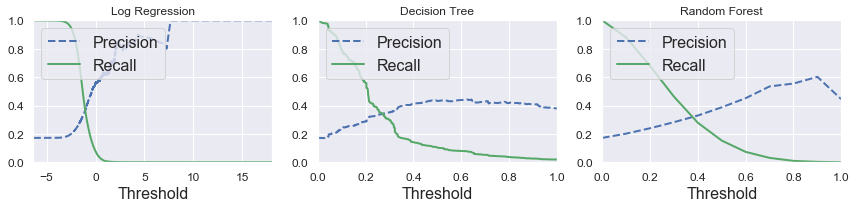

In [110]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.xlim([np.min(thresholds), np.max(thresholds)])

plt.figure(figsize=(12, 3))
plt.subplot(131)
plot_precision_recall_vs_threshold(log_precisions, log_recalls, log_thresholds)
plt.title('Log Regression')
plt.subplot(132)
plot_precision_recall_vs_threshold(tree_precisions, tree_recalls, tree_thresholds)
plt.title('Decision Tree')
plt.subplot(133)
plot_precision_recall_vs_threshold(forest_precisions, forest_recalls, forest_thresholds)
plt.title('Random Forest')

save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


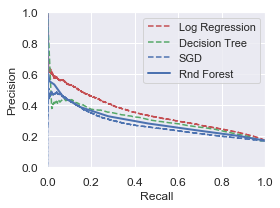

In [111]:
def plot_precision_vs_recall(recalls, precisions, label=None):
    plt.plot(recalls, precisions, linewidth=2, label=label)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(4, 3))
plt.plot(log_recalls, log_precisions, 'r--', label='Log Regression')
plt.plot(tree_recalls, tree_precisions, 'g--', label='Decision Tree')
plt.plot(sgd_recalls, sgd_precisions, 'b--', label='SGD')
plot_precision_vs_recall(forest_recalls, forest_precisions, label='Rnd Forest')
plt.legend(loc='upper right')

save_fig("precision_vs_recall_plot")
plt.show()

### ROC Curves

In [112]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Rnd Classifier')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

In [113]:
log_fpr, log_tpr, log_thresholds = roc_curve(y_train, log_scores)

In [114]:
tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_train, tree_scores)

In [115]:
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_train, forest_scores)

In [116]:
sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(y_train, sgd_scores)

Saving figure roc_curves_plot


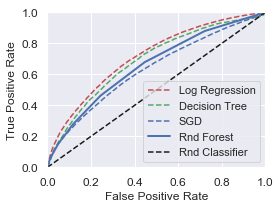

In [117]:
plt.figure(figsize=(4, 3))
plt.plot(log_fpr, log_tpr, 'r--', label='Log Regression')
plt.plot(tree_fpr, tree_tpr, 'g--', label='Decision Tree')
plt.plot(sgd_fpr, sgd_tpr, 'b--', label='SGD')
plot_roc_curve(forest_fpr, forest_tpr, "Rnd Forest")
plt.legend(loc='lower right')
save_fig("roc_curves_plot")
plt.show()

## Fine-tune the Model

### Grid Search

In [118]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [5, 10, 50], 
     'max_features': [10, 15, 20],
     'max_depth': [10, 15, 20]},
    {'bootstrap': [False],
     'n_estimators': [5, 10, 50],
     'max_features': [10, 15, 20],
     'max_depth': [10, 15, 20]}
]

forest_clf = RandomForestClassifier(random_state=42)
forest_grd_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring='f1',
                                  return_train_score=True, verbose=2, n_jobs=-1)
forest_grd_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  4.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 50], 'max_features': [10, 15, 20], 'max_depth': [10, 15, 20]}, {'bootstrap': [False], 'n_estimators': [5, 10, 50], 'max_features': [10, 15, 20], 'max_depth': [10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=2)

In [119]:
forest_grd_search.best_params_

{'bootstrap': False, 'max_depth': 20, 'max_features': 20, 'n_estimators': 5}

In [120]:
forest_grd_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [121]:
forest_grd_pred = forest_grd_search.best_estimator_.predict(X_train_prepared)
forest_grd_proba = forest_grd_search.best_estimator_.predict_proba(X_train_prepared)
forest_grd_scores = forest_grd_proba[:,1]
display_scores(y_train, forest_grd_pred, forest_grd_scores)

Precision:  0.9948131783690327
Recall:     0.5688783917389871
F1:         0.7238354824055632
ROC AUC:    0.9736075548747984
[[87568    54]
 [ 7849 10357]]


In [122]:
forest_grd_fpr, forest_grd_tpr, forest_grd_thresholds = roc_curve(y_train, forest_grd_scores)

Saving figure roc_curves_after_gridsearch_plot


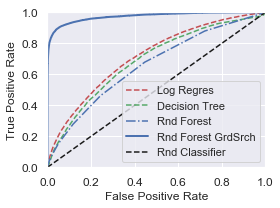

In [123]:
plt.figure(figsize=(4, 3))
plt.plot(log_fpr, log_tpr, 'r--', label='Log Regres')
plt.plot(tree_fpr, tree_tpr, 'g--', label='Decision Tree')
plt.plot(forest_fpr, forest_tpr, 'b-.', label='Rnd Forest')
plot_roc_curve(forest_grd_fpr, forest_grd_tpr, "Rnd Forest GrdSrch")
plt.legend(loc='lower right')
save_fig("roc_curves_after_gridsearch_plot")
plt.show()

### Randomized Grid Search

In [124]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'bootstrap':[False],
    'n_estimators': randint(low=5, high=30),
    'max_features': randint(low=5, high=25),
    'max_depth': randint(low=5, high=25)
    }

forest_clf = RandomForestClassifier(random_state=42)
forest_rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                       n_iter=50, cv=3, scoring='f1', return_train_score=True,
                                       random_state=42, verbose=2, n_jobs=-1)
forest_rnd_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'bootstrap': [False], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026D2B083B38>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026D2B07A5F8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026D2B07AF28>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='f1', verbos

In [125]:
forest_rnd_search.best_params_

{'bootstrap': False, 'max_depth': 22, 'max_features': 16, 'n_estimators': 6}

In [126]:
forest_rnd_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=22, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [127]:
forest_rnd_pred = forest_rnd_search.best_estimator_.predict(X_train_prepared)

forest_rnd_proba = forest_rnd_search.best_estimator_.predict_proba(X_train_prepared)
forest_rnd_scores = forest_rnd_proba[:,1]

display_scores(y_train, forest_rnd_pred, forest_rnd_scores)

Precision:  0.9986527450319973
Recall:     0.6514335933208832
F1:         0.788511402167409
ROC AUC:    0.9894955432494978
[[87606    16]
 [ 6346 11860]]


In [128]:
forest_rnd_fpr, forest_rnd_tpr, forest_rnd_thresholds = roc_curve(y_train, forest_rnd_scores)

Saving figure roc_curves_after_randomsearch_plot


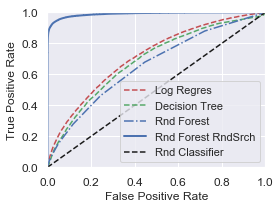

In [129]:
plt.figure(figsize=(4, 3))
plt.plot(log_fpr, log_tpr, 'r--', label='Log Regres')
plt.plot(tree_fpr, tree_tpr, 'g--', label='Decision Tree')
plt.plot(forest_fpr, forest_tpr, 'b-.', label='Rnd Forest')
plot_roc_curve(forest_rnd_fpr, forest_rnd_tpr, "Rnd Forest RndSrch")
plt.legend(loc='lower right')
save_fig("roc_curves_after_randomsearch_plot")
plt.show()

### Final Model

In [130]:
final_model = forest_rnd_search.best_estimator_
final_model

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=22, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Feature Importances

In [131]:
feature_importances = final_model.feature_importances_

In [132]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.05915961767173623, 'latitude'),
 (0.057528040939994, 'longitude'),
 (0.05564403387103827, 'Engine_Capacity_(CC)'),
 (0.0515673957737677, 'Age_of_Driver'),
 (0.04061666035563465, 'minute'),
 (0.040197633706438994, '1st_road_number'),
 (0.03970824333663311, 'day'),
 (0.039075620261060755, 'week'),
 (0.0386938330248874, 'Age_of_Vehicle'),
 (0.038107213045170486, 'hour'),
 (0.03536964478211371, 'Car'),
 (0.033209914668896695, 'Motorcycle over 500cc'),
 (0.031735690545624994, 'casualties_per_vehicle'),
 (0.027349013091132357, 'month'),
 (0.021191358488545888, 'speed_limit'),
 (0.0151202129822363, 'number_of_casualties'),
 (0.013570314528720482, '2nd_road_number'),
 (0.011580610077405707, 'Male'),
 (0.009886514698659634, 'Female'),
 (0.009418951919095532, 'number_of_vehicles'),
 (0.009115763824390255, 'Pedal cycle'),
 (0.00901529090326351,
  'Approaching junction or waiting/parked at junction approach'),
 (0.008559063648032175, 'Urban'),
 (0.00822409589536124, 'Mid Junction - on roundabo

The higher, the more important the feature is. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance

Saving figure feature_importances_plot


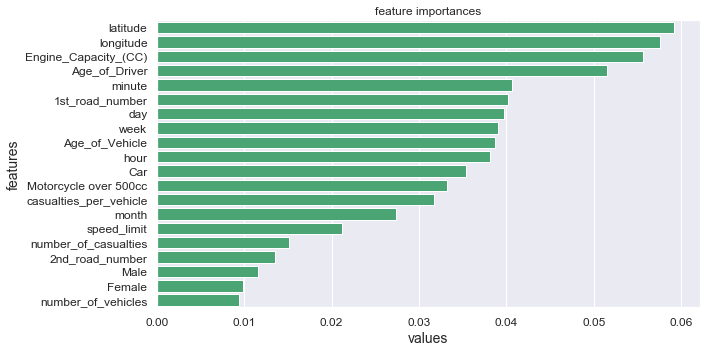

In [133]:
indices = np.argsort(feature_importances)[::-1]

ranking = pd.DataFrame({'features':[attributes[indices[f]] for f in range(len(attributes[:20]))],
                        'values': [feature_importances[indices[f]] for f in range(len(attributes[:20]))]})

plt.figure(figsize=(10, 5))
sns.barplot(x='values', y='features', data=ranking, orient='h', color='mediumseagreen')
plt.title('feature importances')
save_fig("feature_importances_plot")
plt.show()

## Evaluate the model on the Test Set

In [134]:
accidents = test_set.copy()

In [135]:
vehicle_adder = AddVehiclesAttributes()

In [136]:
X_test = vehicle_adder.transform(accidents)
X_test.info()

AddVehiclesAttributes transform
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26418 entries, 121968 to 134074
Data columns (total 67 columns):
accident_id                                                    26418 non-null int64
location_easting_osgr                                          26418 non-null float64
location_northing_osgr                                         26418 non-null float64
longitude                                                      26418 non-null float64
latitude                                                       26418 non-null float64
number_of_vehicles                                             26418 non-null int64
number_of_casualties                                           26418 non-null int64
date                                                           26418 non-null object
time                                                           26418 non-null object
1st_road_class                                                 26418 non-null object
1s

In [137]:
X_test_prepared = preprocess_pipeline.transform(X_test)
y_test = X_test['target']

DataFrameSelector transform
attributes names: ['longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties', '1st_road_number', 'speed_limit', '2nd_road_number', 'Female', 'Male', 'Not known', 'Agricultural vehicle', 'Bus or coach (17 or more pass seats)', 'Car', 'Electric motorcycle', 'Goods 7.5 tonnes mgw and over', 'Goods over 3.5t. and under 7.5t', 'Goods vehicle - unknown weight', 'Minibus (8 - 16 passenger seats)', 'Mobility scooter', 'Motorcycle - unknown cc', 'Motorcycle 125cc and under', 'Motorcycle 50cc and under', 'Motorcycle over 125cc and up to 500cc', 'Motorcycle over 500cc', 'Other vehicle', 'Pedal cycle', 'Ridden horse', 'Taxi/Private hire car', 'Tram', 'Van / Goods 3.5 tonnes mgw or under', 'No', 'Yes', 'Approaching junction or waiting/parked at junction approach', 'Cleared junction or waiting/parked at junction exit', 'Entering from slip road', 'Entering main road', 'Entering roundabout', 'Leaving main road', 'Leaving roundabout', 'Mid Junction - on roundabou

In [138]:
print(X_test_prepared.shape)
print(y_test.shape)

(26418, 152)
(26418,)


In [139]:
y_pred = final_model.predict(X_test_prepared)
y_proba = final_model.predict_proba(X_test_prepared)
y_scores = y_proba[:,1]

In [140]:
display_scores(y_test, y_pred, y_scores)

Precision:  0.4050632911392405
Recall:     0.0979020979020979
F1:         0.15769095388947554
ROC AUC:    0.6742623577434378
[[21184   658]
 [ 4128   448]]


# Final Model - Make Predictions

In [141]:
test_data = load_transport_data('test.csv')

In [142]:
accidents = test_data.copy()

In [143]:
X_pred = vehicle_adder.transform(accidents)
X_pred.info()

AddVehiclesAttributes transform
<class 'pandas.core.frame.DataFrame'>
Int64Index: 103409 entries, 0 to 129949
Data columns (total 66 columns):
accident_id                                                    103409 non-null int64
location_easting_osgr                                          103409 non-null float64
location_northing_osgr                                         103409 non-null float64
longitude                                                      103409 non-null float64
latitude                                                       103409 non-null float64
number_of_vehicles                                             103409 non-null int64
number_of_casualties                                           103409 non-null int64
date                                                           103409 non-null object
time                                                           103409 non-null object
1st_road_class                                                 103409 non-null obj

In [144]:
def check_categoricals_in_test_set(X_pred, X_train, col):
    flag = np.in1d(X_pred[col].value_counts().index, X_train[col].value_counts().index).all()
    print(flag)
    if not flag:
        val = np.extract(np.logical_not(np.in1d(X_pred[col].value_counts().index,X_train[col].value_counts().index)),
                         X_pred[col].value_counts().index)
        print(val)
        print(X_pred[col].value_counts())
        idx = np.extract(X_pred[col].isin(val), X_pred.index)
        X_pred.loc[idx, col] = np.nan
    return X_pred

In [145]:
X_pred = check_categoricals_in_test_set(X_pred, X_train, 'urban_or_rural_area')

False
['Unallocated']
Urban          64235
Rural          39173
Unallocated        1
Name: urban_or_rural_area, dtype: int64


In [146]:
X_pred_prepared = preprocess_pipeline.transform(X_pred)
X_pred_prepared.shape

DataFrameSelector transform
attributes names: ['longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties', '1st_road_number', 'speed_limit', '2nd_road_number', 'Female', 'Male', 'Not known', 'Agricultural vehicle', 'Bus or coach (17 or more pass seats)', 'Car', 'Electric motorcycle', 'Goods 7.5 tonnes mgw and over', 'Goods over 3.5t. and under 7.5t', 'Goods vehicle - unknown weight', 'Minibus (8 - 16 passenger seats)', 'Mobility scooter', 'Motorcycle - unknown cc', 'Motorcycle 125cc and under', 'Motorcycle 50cc and under', 'Motorcycle over 125cc and up to 500cc', 'Motorcycle over 500cc', 'Other vehicle', 'Pedal cycle', 'Ridden horse', 'Taxi/Private hire car', 'Tram', 'Van / Goods 3.5 tonnes mgw or under', 'No', 'Yes', 'Approaching junction or waiting/parked at junction approach', 'Cleared junction or waiting/parked at junction exit', 'Entering from slip road', 'Entering main road', 'Entering roundabout', 'Leaving main road', 'Leaving roundabout', 'Mid Junction - on roundabou

(103409, 152)

In [147]:
y_pred = final_model.predict(X_pred_prepared)
y_proba = final_model.predict_proba(X_pred_prepared)[:,1]

In [148]:
predictions = pd.DataFrame({'accident_id':X_pred['accident_id'].values.ravel(),
                            'target':y_pred.ravel(),
                            'probability':y_proba.ravel()})

In [149]:
predictions.sort_values(by='probability', inplace=True, ascending=False)
predictions.reset_index(drop=True, inplace=True)

In [150]:
OUTPUT = 'outputs'
predictions[['accident_id', 
             'target',
             'probability']].to_csv(os.path.join(PROJECT_ROOT_DIR, OUTPUT, 'predictions_georchat.csv'))

In [151]:
predictions.describe()

,accident_id,target,probability
count,103409.000000,103409.000000,103409.000000
mean,449981.191947,0.046737,0.184803
std,86693.803901,0.211075,0.156536
min,300003.000000,0.000000,0.000000
25%,374879.000000,0.000000,0.053956
50%,450017.000000,0.000000,0.157794
75%,525274.000000,0.000000,0.261055
max,599998.000000,1.000000,1.000000
